In [1]:
import os

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from models import VBPR, ACF, CuratorNet
from utils.data import extract_embedding
from utils.metrics import (
    auc_exact,
    nDCG,
    precision,
    recall,
    reciprocal_rank,
)


# Evaluation procedure

In [2]:
DATASET = "Wikimedia"

# Model
MODEL = "ACF"
assert MODEL in ["CuratorNet", "VBPR", "ACF"]

FEATURE_EXTRACTOR = "resnet50"
assert FEATURE_EXTRACTOR in ["alexnet", "vgg16", "resnet50"]

FEATURE_LAYER = "layer4"
FEATURE_LAYER = FEATURE_LAYER if MODEL is "ACF" else "" 

<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-713c1445f697>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  FEATURE_LAYER = FEATURE_LAYER if MODEL is "ACF" else ""


In [3]:
# Mode
# Use 'MODE_PROFILE = True' for CuratorNet-like training 
# Use 'MODE_PROFILE = False' for VBPR-like training
MODE_PROFILE = MODEL in ["CuratorNet"]
MODE_PROFILE = "profile" if MODE_PROFILE else "user"

# Checkpoint (ex. 'VBPR_wikimedia')
CHECKPOINT = f"{MODEL}_wikimedia"

In [4]:
# Paths (general)
CHECKPOINT_EXT = "pt" if MODEL is "ACF" else "tar" 
CHECKPOINT_PATH = os.path.join("checkpoints", f"{CHECKPOINT}.{CHECKPOINT_EXT}")
FEATURE_EXTRACTOR = f"{FEATURE_EXTRACTOR}-{FEATURE_LAYER}" if FEATURE_LAYER else FEATURE_EXTRACTOR
EMBEDDING_PATH = os.path.join("data", f"embedding-{FEATURE_EXTRACTOR}.npy")
EVALUATION_PATH = os.path.join("data", f"naive-{MODE_PROFILE}-evaluation.csv")

# Paths (images)
IMAGES_DIR = os.path.join("/", "mnt", "data2", "wikimedia", "imagenes_tarea")

# General constants
RNG_SEED = 0
USE_GPU = True


<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-8dfc4e29e372>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  CHECKPOINT_EXT = "pt" if MODEL is "ACF" else "tar"


In [5]:
# Freezing RNG seed if needed
if RNG_SEED is not None:
    print(f"\nUsing random seed... ({RNG_SEED})")
    torch.manual_seed(RNG_SEED)



Using random seed... (0)


In [6]:
# Load embedding from file
print(f"\nLoading embedding from file... ({EMBEDDING_PATH})")
embedding = np.load(EMBEDDING_PATH, allow_pickle=True)

# Extract features and "id2index" mapping
print("\nExtracting data into variables...")
features, _, item_index2fn = extract_embedding(embedding, verbose=True)
print(f">> Features shape: {features.shape}")
del embedding  # Release some memory



Loading embedding from file... (data/embedding-resnet50-layer4.npy)

Extracting data into variables...
>> Features shape: (9633, 2048, 7, 7)


In [7]:
# Load evaluation dataframe
print("\nLoad evaluation dataframe")
evaluation_df = pd.read_csv(EVALUATION_PATH)
# Transform lists from str to int
string_to_list = lambda s: list(map(int, s.split()))
evaluation_df["profile"] = evaluation_df["profile"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
evaluation_df["predict"] = evaluation_df["predict"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
# Group evaluations by profile and user
evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
evaluation_df = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
evaluation_df["profile"] = evaluation_df["profile"].map(list)
print(f">> Evaluation: {evaluation_df.shape}")



Load evaluation dataframe
>> Evaluation: (1078, 3)


In [8]:
# Create device instance
print("\nDevice initialization")
device = torch.device("cuda:0" if torch.cuda.is_available() and USE_GPU else "cpu")
if torch.cuda.is_available() != USE_GPU:
    print((f"\nNotice: Not using GPU - "
           f"Cuda available ({torch.cuda.is_available()}) "
           f"does not match USE_GPU ({USE_GPU})"
    ))

# Loading checkpoint
if CHECKPOINT is not None:
    print("\nLoading checkpoint")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))
    if 'epoch' in checkpoint and 'accuracy' in checkpoint:
        print(f">> Best epoch: {checkpoint['epoch']} | Best accuracy: {checkpoint['accuracy']}")
    elif 'epoch' in checkpoint and 'loss' in checkpoint:
        print(f">> Best epoch: {checkpoint['epoch']} | Best Loss: {checkpoint['loss']}")

# Model initialization
print("\nModel initialization")
model = None
checkpoint_loaded = False
if MODEL == "VBPR":
    n_users = checkpoint["model"]["gamma_users.weight"].size(0)
    n_items = checkpoint["model"]["gamma_items.weight"].size(0)
    dim_gamma = checkpoint["model"]["gamma_users.weight"].size(1)
    dim_theta = checkpoint["model"]["theta_users.weight"].size(1)
    model = VBPR(
        n_users, n_items,  # Number of users and items
        torch.Tensor(features),  # Pretrained visual features
        dim_gamma, dim_theta,  # Size of internal spaces
    ).to(device)
elif MODEL == "CuratorNet":
    model = CuratorNet(
        torch.Tensor(features),
        input_size=features.shape[1],
    ).to(device)
elif MODEL == "ACF":
    model = ACF.from_checkpoint(checkpoint, device=device)
    checkpoint_loaded = True
    
# Load state dict
if not checkpoint_loaded and CHECKPOINT is not None:
    model.load_state_dict(checkpoint["model"])

# Change model mode to eval
print("\nChanging model mode to eval")
model.eval()



Device initialization

Loading checkpoint
>> Best epoch: 9 | Best Loss: 0.5654797637524714

Model initialization

Changing model mode to eval


ACF(
  (item_model): Embedding(9634, 128, padding_idx=0)
  (user_model): ACFUserNet(
    (feats): ACFFeatureNet(
      (dim_reductor): Linear(in_features=2048, out_features=128, bias=True)
      (w_x): Linear(in_features=128, out_features=128, bias=True)
      (w_u): Linear(in_features=128, out_features=128, bias=True)
      (w): Linear(in_features=128, out_features=1, bias=True)
    )
    (user_embedding): Embedding(1079, 128)
    (profile_embedding): Embedding(9634, 128, padding_idx=0)
    (w_u): Linear(in_features=128, out_features=128, bias=True)
    (w_v): Linear(in_features=128, out_features=128, bias=True)
    (w_p): Linear(in_features=128, out_features=128, bias=True)
    (w_x): Linear(in_features=128, out_features=128, bias=True)
    (w): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
# Predict all
# If True, ranks every item including already consumed items
# If False, ranks ALL - PROFILE (consumed) + PREDICT (ground truth)
PREDICT_ALL = False


In [10]:
%%time
# Metrics
N_EVALS = len(evaluation_df.index)
# Area Under the Curve (AUC)
AUC = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Reciprocal Rank (RR)
RR = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Recall
R20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
R100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
R200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Precision
P20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
P100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
P200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Normalized discounted cumulative gain (nDCG)
N20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
N100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
N200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
PROFILE_SIZES = torch.zeros([N_EVALS], dtype=int, device=device)
N_ITEMS = len(features)


if MODEL != "ACF":
    cache = model.generate_cache()

evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
grouped_evals = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
for i, row in tqdm(enumerate(evaluation_df.itertuples()), total=len(evaluation_df.index)):
    # Load data into tensors
    profile = torch.tensor(row.profile).to(device, non_blocking=True).unsqueeze(0)
    user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
    predict = torch.tensor(row.predict).to(device, non_blocking=True)
    # Prediction
    if MODEL is "ACF":
        acf_profile = profile + 1 # In ACF items are indexed starting at 1
        scores = model.recommend_all(user_id, acf_profile).squeeze()
    elif MODE_PROFILE == "profile":
        scores = model.recommend_all(profile, cache=cache)
    elif MODE_PROFILE == "user":
        scores = model.recommend_all(user_id, cache=cache).squeeze()
    
    # Ranking
    pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
    if not PREDICT_ALL:
        pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
        # Relevant dimensions
        _a, _b = pos_of_evals.size(0), pos_of_profi.size(0)
        # Calculate shift for each eval item
        shift = (pos_of_profi.expand(_a, _b) < pos_of_evals.reshape(_a, 1).expand(_a, _b)).sum(1)
        # Apply shift
        pos_of_evals -= shift.squeeze(0)
    # Store metrics
    AUC[i] = auc_exact(pos_of_evals, N_ITEMS)
    RR[i] = reciprocal_rank(pos_of_evals)
    R20[i] = recall(pos_of_evals, 20)
    P20[i] = precision(pos_of_evals, 20)
    N20[i] = nDCG(pos_of_evals, 20)
    R100[i] = recall(pos_of_evals, 100)
    P100[i] = precision(pos_of_evals, 100)
    N100[i] = nDCG(pos_of_evals, 100)
    R200[i] = recall(pos_of_evals, 200)
    P200[i] = precision(pos_of_evals, 200)
    N200[i] = nDCG(pos_of_evals, 200)
    PROFILE_SIZES[i] = len(row.profile)


<timed exec>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?


  0%|          | 0/1078 [00:00<?, ?it/s]

<timed exec>:43: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


CPU times: user 17.2 s, sys: 180 ms, total: 17.4 s
Wall time: 4.36 s


In [11]:
# Display stats
print(f"AVG AUC = {AUC.mean()}")
print(f"AVG RR = {RR.mean()}")
print(f"AVG R20 = {R20.mean()}")
print(f"AVG P20 = {P20.mean()}")
print(f"AVG NDCG20 = {N20.mean()}")
print(f"AVG R100 = {R100.mean()}")
print(f"AVG P100 = {P100.mean()}")
print(f"AVG NDCG100 = {N100.mean()}")
print(f"AVG R200 = {R200.mean()}")
print(f"AVG P200 = {P200.mean()}")
print(f"AVG NDCG200 = {N200.mean()}")


AVG AUC = 0.8040931383508431
AVG RR = 0.015949983699329325
AVG R20 = 0.0547309837420471
AVG P20 = 0.0027365491871023553
AVG NDCG20 = 0.021273941757556012
AVG R100 = 0.14935065055033192
AVG P100 = 0.001493506505503319
AVG NDCG100 = 0.03781450285413454
AVG R200 = 0.26530612458009273
AVG P200 = 0.0013265306229004639
AVG NDCG200 = 0.05400109595905897


## Relevant plots

In [12]:
import numpy as np


def smart_group(value):
    if value == 0:
        return 0
    digits = int(np.log10(value)) + 1
    return (10**(digits - 1)) * (value // (10**(digits - 1)))

In [13]:
import pandas as pd


metrics_data = [
    [
        PROFILE_SIZES[i].item(), AUC[i].item(), RR[i].item(),
        R20[i].item(), P20[i].item(), N20[i].item(),
        R100[i].item(), P100[i].item(), N100[i].item(),
    ]
    for i in range(N_EVALS)
]
metrics_df = pd.DataFrame(metrics_data, columns=[
    "PROFILE_SIZES", "AUC", "RR",
    "R20", "P20", "N20",
    "R100", "P100", "N100",
])
metrics_df["PROFILE_SIZES_STEPS"] = metrics_df["PROFILE_SIZES"].map(smart_group)

/home/fidelrio/.pyenv/versions/iui/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/fidelrio/.pyenv/versions/iui/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


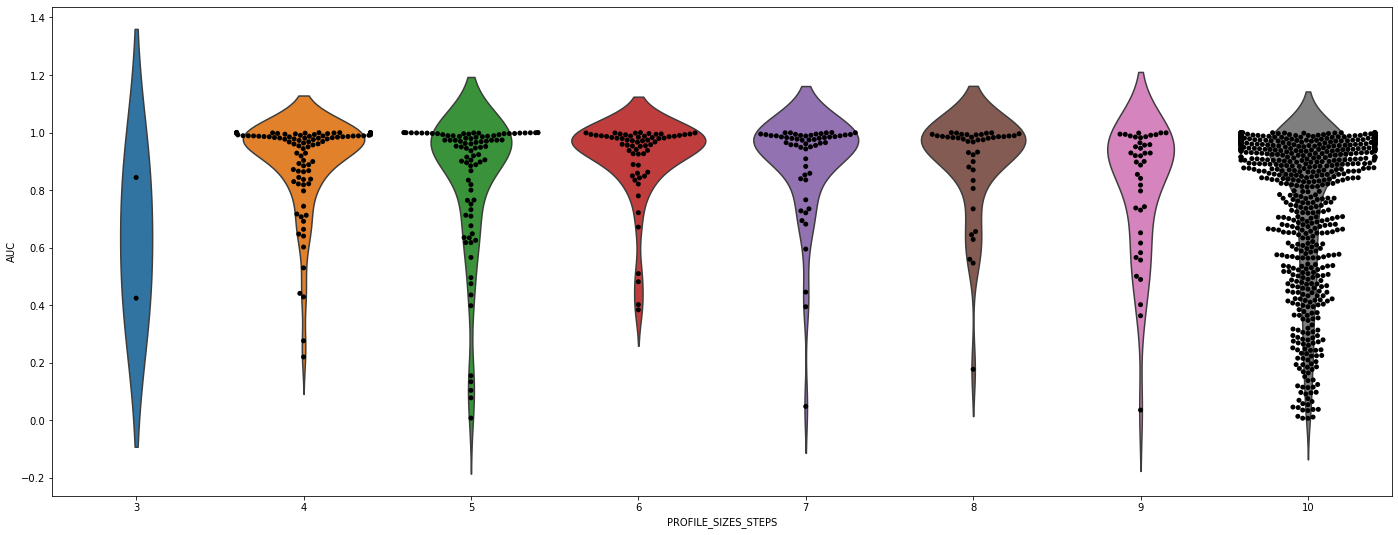

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


# Metric
METRIC = "AUC"
# Profile size range
metrics_df_plot = metrics_df.copy()
metrics_df_plot = metrics_df_plot[
    (metrics_df_plot["PROFILE_SIZES_STEPS"] >= 0) & (metrics_df_plot["PROFILE_SIZES_STEPS"] < 100)
]
# Plot METRIC distribution across users grouped by profile size
plt.figure(figsize=(24, 9))
ax = sns.violinplot(x="PROFILE_SIZES_STEPS", y=METRIC, data=metrics_df_plot, inner=None)
if DATASET != "Pinterest":
    ax = sns.swarmplot(x="PROFILE_SIZES_STEPS", y=METRIC, data=metrics_df_plot, color="black", edgecolor="gray")


<AxesSubplot:>

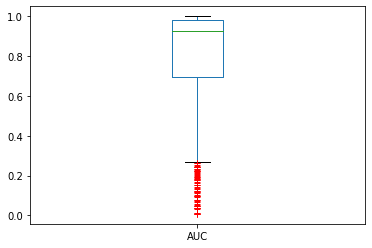

In [15]:
# Area Under the Curve distribution across users
metrics_df["AUC"].plot.box(sym="r+")

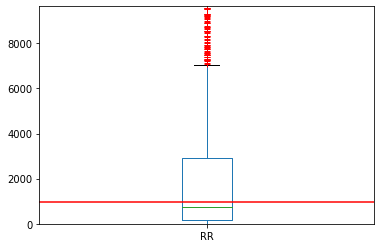

In [16]:
# First relevant item position (1 / reciprocal_rank) distribution across users
# Line marks the 10% of the dataset
graph = (1 / metrics_df["RR"]).plot.box(sym="r+")
plt.ylim(0, features.shape[0])
graph.axhline(features.shape[0] / 10, color="red")

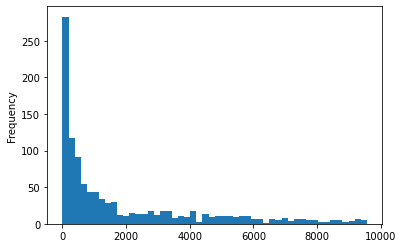

In [17]:
# First relevant item position (1 / reciprocal_rank) histogram
graph = (1 / metrics_df["RR"]).plot.hist(bins=50)

## Results inspection

In [18]:
ROW = 0


In [19]:
# Row in evaluation dataframe
row = evaluation_df.iloc[ROW]

# Load data into tensors
profile = torch.tensor(row.profile).to(device, non_blocking=True).unsqueeze(0)
user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
predict = torch.tensor(row.predict).to(device, non_blocking=True)
# Prediction
if MODEL == "ACF":
    acf_profile = profile + 1
    scores = model.recommend_all(user_id, acf_profile).squeeze()
elif MODE_PROFILE == "profile":
    scores = model.recommend_all(profile)
elif MODE_PROFILE == "user":
    scores = model.recommend_all(user_id).squeeze()
# Ranking
pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
if not PREDICT_ALL:
    pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
    pos_of_evals -= (pos_of_profi < pos_of_evals).sum()

# Display metrics
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'Metric':^15} | {'Score':^7} |")
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'AUC':^15} | {auc_exact(pos_of_evals, N_ITEMS):.5f} |")
print(f"| {'RR':^15} | {reciprocal_rank(pos_of_evals):.5f} |")
for k in [20, 100, 500]:
    print(f"| {'-' * 15} | {'-' * 7} |")
    print(f"| {f'Recall@{k}':^15} | {recall(pos_of_evals, k):.5f} |")
    print(f"| {f'Precision@{k}':^15} | {precision(pos_of_evals, k):.5f} |")
    print(f"| {f'nDCG@{k}':^15} | {nDCG(pos_of_evals, k):.5f} |")
print(f"| {'-' * 15} | {'-' * 7} |")

# Profile and prediction
profile = profile.cpu().numpy().flatten()
predict = predict.cpu().numpy().flatten()
# Ranking
K = 20
ranking = torch.argsort(scores, descending=True).cpu().numpy().flatten()
if not PREDICT_ALL:
    ranking = ranking[(~np.isin(ranking, profile)) | (np.isin(ranking, predict))]
ranking = ranking[:K]
print()
print(f"Size of profile: {profile.size}")
print(f"Position of actual items: {pos_of_evals.cpu().numpy()}")


| --------------- | ------- |
|     Metric      |  Score  |
| --------------- | ------- |
|       AUC       | 0.97436 |
|       RR        | 0.00403 |
| --------------- | ------- |
|    Recall@20    | 0.00000 |
|  Precision@20   | 0.00000 |
|     nDCG@20     | 0.00000 |
| --------------- | ------- |
|   Recall@100    | 0.00000 |
|  Precision@100  | 0.00000 |
|    nDCG@100     | 0.00000 |
| --------------- | ------- |
|   Recall@500    | 1.00000 |
|  Precision@500  | 0.00200 |
|    nDCG@500     | 0.12563 |
| --------------- | ------- |

Size of profile: 7
Position of actual items: [247]


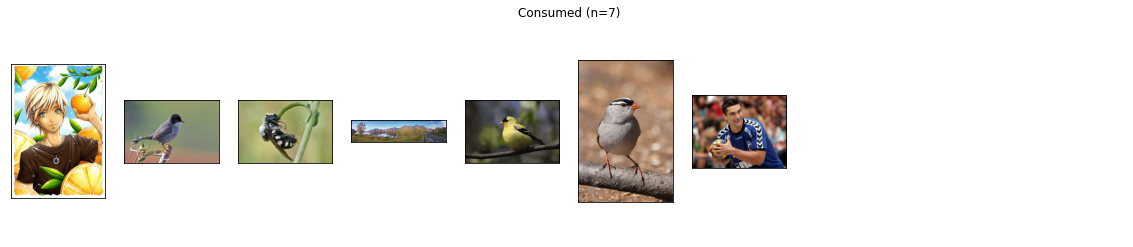

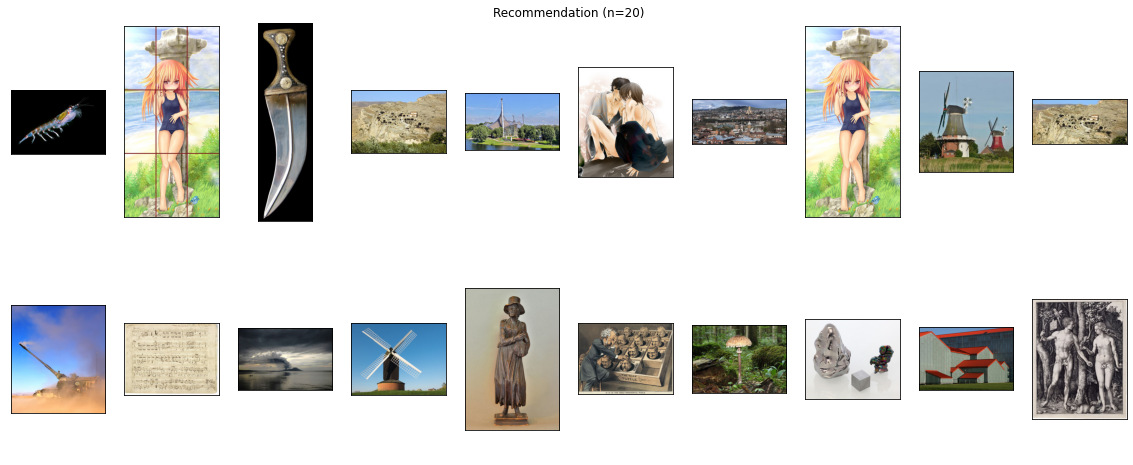

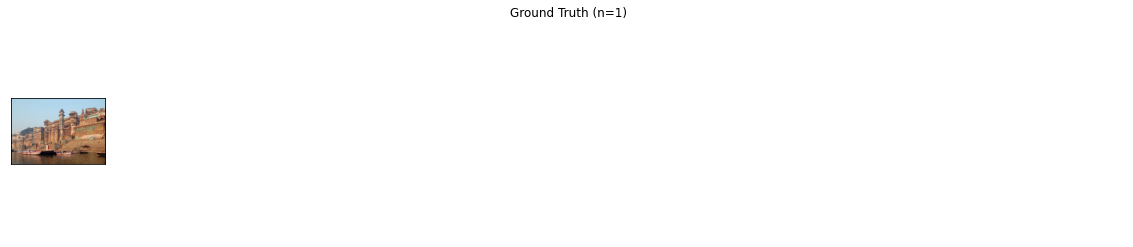

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


COLUMNS = 10
ELEMENTS = {
    "Consumed": profile,
    "Recommendation": ranking,
    "Ground truth": predict,
}
SHOW_FILENAME = False

for label, items in ELEMENTS.items():
    n_rows = ((len(items) - 1) // COLUMNS + 1)
    fig = plt.figure(figsize=(COLUMNS * 2, 4 * n_rows))
    plt.title(f"{label.title()} (n={len(items)})")
    plt.axis("off")
    for i, img_id in enumerate(items, start=1):
        img_fn = item_index2fn[img_id]
        image = mpimg.imread(os.path.join(IMAGES_DIR, img_fn))
        ax = fig.add_subplot(n_rows, COLUMNS, i)
        if SHOW_FILENAME:
            ax.set_title(img_fn)
        if label == "Recommendation":
            if img_id in predict:
                ax.patch.set_edgecolor("green")
                ax.patch.set_linewidth("5")
                if SHOW_FILENAME:
                    ax.set_title(img_fn, color="green")
                else:
                    ax.set_title("Ground truth", color="green")
            elif img_id in profile:
                ax.patch.set_edgecolor("red")
                ax.patch.set_linewidth("5")
                if SHOW_FILENAME:
                    ax.set_title(img_fn, color="red")
                else:
                    ax.set_title("Consumed", color="red")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
